### Querying Knowledge Graphs with Cypher

In [1]:
import os
from dotenv import load_dotenv

from langchain_community.graphs import Neo4jGraph

# for visualizing graph database
from yfiles_jupyter_graphs import GraphWidget

In [2]:
load_dotenv()

NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = os.getenv("NEO4J_DATABASE")

### Initialize a knowledge graph instance using LangChain's Neo4j integration

In [3]:
graph = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database=NEO4J_DATABASE
)

### Create Entries in the Database
In this step, we are adding entries to the graph database. We are only creating nodes without establishing any relationships between them. This means the data in the database consists solely of nodes, with no connections between them. The query to create these records can be found in `data/dummy/movies_cypher.txt`.

In [4]:
PATH_TO_CYPHER_FOR_DB_ENTRIES = "data/dummy/movies_cypher.txt"
# open sample database
with open(PATH_TO_CYPHER_FOR_DB_ENTRIES) as fp:
    content = fp.read()

# create sample database
graph.query(content)

[]

### Visualization of database

In [5]:
# see the plot of graph database after adding data to Neo4j
from neo4j import GraphDatabase

# directly show the graph resulting from the given Cypher query
# default_cypher = "MATCH (s)-[r:!MENTIONS]->(t) RETURN s,r,t LIMIT 50"
default_cypher = "MATCH (n) RETURN n LIMIT 50"

def showGraph(cypher: str = default_cypher):
    # create a neo4j session to run queries
    driver = GraphDatabase.driver(
        uri = os.environ["NEO4J_URI"],
        auth = (os.environ["NEO4J_USERNAME"],
                os.environ["NEO4J_PASSWORD"]))
    session = driver.session()
    widget = GraphWidget(graph = session.run(cypher).graph())
    widget.node_label_mapping = 'id'
    #display(widget)
    return widget

showGraph()

GraphWidget(layout=Layout(height='800px', width='100%'))

### Querying the Movie Knowledge Graph
- Match all nodes in the graph

In [6]:
cypher = """
    MATCH (n)
    RETURN count(n)
    """
result = graph.query(cypher)
result

[{'count(n)': 157}]

In [7]:
cypher = """
    MATCH (n:Movie)
    RETURN count(n) AS numberOfNodes
    """
result = graph.query(cypher)
result

[{'numberOfNodes': 36}]

In [8]:
print(f"There are {result[0]['numberOfNodes']} nodes in this graph")

There are 36 nodes in this graph


#### Match only `Movie` nodes by specifying the node label

In [9]:
cypher = """
    MATCH (n:Movie)
    RETURN count(n) AS numberOfMovies
    """
graph.query(cypher)

[{'numberOfMovies': 36}]

#### Match only `Person` nodes

In [10]:
cypher = """
    MATCH (people:Person)
    RETURN count(people) AS numberOfPeople
    """
graph.query(cypher)

[{'numberOfPeople': 121}]

#### Match a single person by specifying the value of the `name` property on `Person` node

In [11]:
cypher = """
    MATCH (tom:Person {name: "Tom Hanks"})
    RETURN tom
    """
graph.query(cypher)

[{'tom': {'born': 1956, 'name': 'Tom Hanks'}}]

#### Match a single person by specifying the value of `name` property on the `Person` node

In [12]:
cypher = """
    MATCH (cloudAtlas: Movie {title: "Cloud Atlas"})
    RETURN cloudAtlas.released
    """
graph.query(cypher)

[{'cloudAtlas.released': 2012}]

#### Return two properties

In [13]:
cypher = """
    MATCH (cloudAtlas:Movie {title: "Cloud Atlas"})
    RETURN cloudAtlas.released, cloudAtlas.tagline
    """
graph.query(cypher)

[{'cloudAtlas.released': 2012,
  'cloudAtlas.tagline': 'Everything is connected'}]

### Cypher patterns with conditional matching

In [14]:
# get the movie which is released between 1900 and 2000
# AND return movie title
cypher = """
    MATCH (nineties: Movie)
    WHERE nineties.released >= 1990
        AND nineties.released < 2000
    RETURN nineties.title
    """
graph.query(cypher)

[{'nineties.title': 'The Matrix'},
 {'nineties.title': "The Devil's Advocate"},
 {'nineties.title': 'A Few Good Men'},
 {'nineties.title': 'As Good as It Gets'},
 {'nineties.title': 'What Dreams May Come'},
 {'nineties.title': 'Snow Falling on Cedars'},
 {'nineties.title': "You've Got Mail"},
 {'nineties.title': 'Joe Versus the Volcano'},
 {'nineties.title': 'When Harry Met Sally'},
 {'nineties.title': 'That Thing You Do'},
 {'nineties.title': 'The Birdcage'},
 {'nineties.title': 'Unforgiven'},
 {'nineties.title': 'Johnny Mnemonic'},
 {'nineties.title': 'Apollo 13'},
 {'nineties.title': 'Twister'},
 {'nineties.title': 'Bicentennial Man'},
 {'nineties.title': 'A League of Their Own'},
 {'nineties.title': 'The Green Mile'}]

#### Pattern matching with multiple nodes

In [15]:
# get the person who are acted in movie and return that person name and movie title he work with
# return only 10 records
cypher = """
    MATCH (actor:Person)-[:ACTED_IN]->(movie:Movie)
    RETURN actor.name, movie.title LIMIT 10
    """
graph.query(cypher)

[]

In [16]:
# return the all movie acted by "Tom Hanks"
cypher = """
    MATCH (tom:Person {name: "Tom Hanks"})-[:ACTED_IN]->(tomHanksMovies:Movie)
    RETURN tom.name, tomHanksMovies.title
    """
graph.query(cypher)

[]

In [17]:
# get name of co-actor who acted in same movie as "Tom Hanks"
cypher = """
    MATCH (tom:Person {name: "Tom Hanks"})-[:ACTED_IN]->(m)<-[:ACTED_IN]-(coActors)
    RETURN coActors.name, m.title
    """
graph.query(cypher)

[]

#### Delete data from Graph

In [18]:
cypher = """
    MATCH (emil:Person {name:"Emil Eifrem"})-[actedIn:ACTED_IN]->(movie:Movie)
    RETURN emil.name, movie.title
    """
graph.query(cypher)

[]

In [19]:
# delete record from the Graph
cypher = """
    MATCH (emil:Person {name: "Emil Eifrem"})-[actedIn:ACTED_IN]->(movie:Movie)
    DELETE actedIn
    """
graph.query(cypher)

[]

#### Adding data to the Graph

In [20]:
cypher = """
    CREATE (andreas:Person {name:"Andres"})
    RETURN andreas
    """

graph.query(cypher)

[{'andreas': {'name': 'Andres'}}]

In [21]:
cypher = """
    MATCH (andreas:Person {name: "Andres"}), (emil:Person {name: "Emil Eifrem"})
    MERGE (andreas)-[hasRelationship:WORKS_WITH]->(emil)
    RETURN andreas, hasRelationship, emil
    """
graph.query(cypher)

[{'andreas': {'name': 'Andres'},
  'hasRelationship': ({'name': 'Andres'},
   'WORKS_WITH',
   {'born': 1978, 'name': 'Emil Eifrem'}),
  'emil': {'born': 1978, 'name': 'Emil Eifrem'}}]

### Relation Visualization
The visualization of relationship in database in neo4j is:

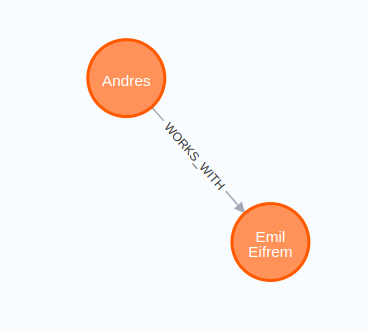